In [1]:
import numpy as np
import pandas as pd
import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random

In [2]:
df = pd.read_csv('data/AAPL_2024-06-16.csv')
df

,timestamp,open,high,low,close,volume
0,1999-11-01,80.00,80.69,77.37,77.62,2487300
1,1999-11-02,78.00,81.69,77.31,80.25,3564600
2,1999-11-03,81.62,83.25,81.00,81.50,2932700
3,1999-11-04,82.06,85.37,80.62,83.62,3384700
4,1999-11-05,84.62,88.37,84.00,88.31,3721500
...,...,...,...,...,...,...
6190,2024-06-10,196.90,197.30,192.15,193.12,97262077
6191,2024-06-11,193.65,207.16,193.63,207.15,172373296
6192,2024-06-12,207.37,220.20,206.90,213.07,198134293
6193,2024-06-13,214.74,216.75,211.60,214.24,97862729


In [4]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

In [3]:
def split_data(data, training_split, features):
  split_row = int(data.shape[0]*training_split)
  training_set = data[features].iloc[:split_row].values
  testing_set = data[features].iloc[split_row:].values
  return training_set, testing_set


def get_x_y(dataset, window_size, label_feature, feature_count):
  X, y = [], []
  for i in range(window_size, len(dataset)):
    X.append(dataset[i-window_size:i])
    y.append(dataset[i, label_feature])

  X, y = np.array(X), np.array(y)
  X = np.reshape(X, (X.shape[0], window_size, feature_count))
  return X, y

In [5]:
training_set, testing_set = split_data(df, 0.8, ['open', 'high', 'low', 'close', 'volume'])
print("training_set: ", training_set.shape)
print("testing_set: ", testing_set.shape)

training_set:  (4956, 5)
testing_set:  (1239, 5)


In [6]:
training_set

array([[8.0000000e+01, 8.0690000e+01, 7.7370000e+01, 7.7620000e+01,
        2.4873000e+06],
       [7.8000000e+01, 8.1690000e+01, 7.7310000e+01, 8.0250000e+01,
        3.5646000e+06],
       [8.1620000e+01, 8.3250000e+01, 8.1000000e+01, 8.1500000e+01,
        2.9327000e+06],
       ...,
       [2.0331000e+02, 2.0439000e+02, 2.0171000e+02, 2.0175000e+02,
        2.0191842e+07],
       [2.0245000e+02, 2.0400000e+02, 2.0220000e+02, 2.0330000e+02,
        1.7595212e+07],
       [2.0409000e+02, 2.0587000e+02, 2.0400000e+02, 2.0521000e+02,
        1.6947420e+07]])

In [7]:
# Example data preparation
scaler = MinMaxScaler()

training_set = scaler.fit_transform(training_set)
testing_set = scaler.fit_transform(testing_set)

In [8]:
training_set

array([[0.09719764, 0.09756027, 0.09412535, 0.09361665, 0.00945048],
       [0.09429666, 0.09900561, 0.094038  , 0.09743389, 0.01515476],
       [0.09954745, 0.10126033, 0.09941035, 0.09924816, 0.01180887],
       ...,
       [0.27605814, 0.2763485 , 0.27515469, 0.27378153, 0.10319569],
       [0.27481071, 0.27578482, 0.27586809, 0.27603123, 0.08944658],
       [0.27718952, 0.2784876 , 0.27848875, 0.27880345, 0.08601654]])

In [9]:
X_train, y_train = get_x_y(training_set, 14, 3, 5)
val_split_row = int(X_train.shape[0]*0.8) # 20% will be used for validation
X_train, X_val = X_train[:val_split_row], X_train[val_split_row:]
y_train, y_val = y_train[:val_split_row], y_train[val_split_row:]
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)

X_train:  (3953, 14, 5)
y_train:  (3953,)
X_val:  (989, 14, 5)
y_val:  (989,)


In [10]:
y_train

array([0.11512671, 0.11248512, 0.11566373, ..., 0.14845133, 0.14805945,
       0.1486255 ])

In [13]:
def grid_search_build_model(window_size, feature_count, lstm_units, d, dense_units):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(window_size, feature_count), return_sequences=True))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(LSTM(lstm_units))
    model.add(Dropout(d))
    model.add(Dense(dense_units, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['mae'])
    return model

In [17]:
lstm_units = [32, 64, 128, 256]
lstm_dropout = [0.1, 0.2, 0.3]
dense_units = [16, 32]
batch_size = [16, 32, 64]
epochs = [25, 50, 100]

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

dictionary_of_training = {'lstm_unit': [], 'lstm_dropout': [], 'dense_units' : [], 'batch_size': [], 'epochs': [], 'training_error_rate': [], 'training_accuracy': [], 'testing_error_rate': [], 'testing_accuracy' : []}

for unit in lstm_units:
    for dropout in lstm_dropout:
        for dense_unit in dense_units:
            for batch in batch_size:
                for epoch in epochs: 
                    # Add current hyperparameters to the dictionary
                    dictionary_of_training['lstm_unit'].append(unit)
                    dictionary_of_training['lstm_dropout'].append(dropout)
                    dictionary_of_training['dense_units'].append(dense_unit)
                    dictionary_of_training['batch_size'].append(batch)
                    dictionary_of_training['epochs'].append(epoch)

                    # Create and compile the model
                    model = grid_search_build_model(14, 5, unit, dropout, dense_unit)

                    # Train the model
                    history = model.fit(X_train, y_train, batch_size=batch, epochs=epoch,
                                        validation_data=(X_val, y_val), verbose=2, callbacks=[early_stopping, reduce_lr])

                    # Evaluate the model on training data
                    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
                    dictionary_of_training['training_error_rate'].append(train_loss)
                    dictionary_of_training['training_accuracy'].append(train_accuracy)

                    # Evaluate the model on validation data
                    test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=0)
                    dictionary_of_training['testing_error_rate'].append(test_loss)
                    dictionary_of_training['testing_accuracy'].append(test_accuracy)

                    # Print progress
                    print(f"Completed training for unit_2={unit}, dropout={dropout}, dense_units={dense_unit}, batch_size={batch}, epochs={epoch}")

                    f = open("model_performances_grid_search.txt", "a")
                    f.write(f"Completed training for unit_2={unit}, dropout={dropout}, dense_units={dense_unit}, batch_size={batch}, epochs={epoch}, training_error_rate={train_loss}, training_accuracy={train_accuracy}, testing_error_rate={test_loss}, testing_accuracy={test_accuracy}\n")
                    f.close()


max_index = np.argmax(dictionary_of_training['testing_accuracy'])

# Print the values corresponding to that index
f = open("model_performances_grid_search.txt", "a")
f.write("Best parameters based on highest testing accuracy:\n")
f.write(f"lstm_unit_1: {dictionary_of_training['lstm_unit_1'][max_index]}\n")
f.write(f"lstm_unit_2: {dictionary_of_training['lstm_unit_2'][max_index]}\n")
f.write(f"lstm_dropout: {dictionary_of_training['lstm_dropout'][max_index]}\n")
f.write(f"dense_units: {dictionary_of_training['dense_units'][max_index]}\n")
f.write(f"batch_size: {dictionary_of_training['batch_size'][max_index]}\n")
f.write(f"epochs: {dictionary_of_training['epochs'][max_index]}")
f.write(f"training_error_rate: {dictionary_of_training['training_error_rate'][max_index]}\n")
f.write(f"training_accuracy: {dictionary_of_training['training_accuracy'][max_index]}\n")
f.write(f"testing_error_rate: {dictionary_of_training['testing_error_rate'][max_index]}\n")
f.write(f"testing_accuracy: {dictionary_of_training['testing_accuracy'][max_index]}\n")

Epoch 1/25


c:\Users\blkeu\anaconda3\envs\CS172B311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


248/248 - 4s - 15ms/step - loss: 0.0137 - mae: 0.0532 - val_loss: 8.9278e-05 - val_mae: 0.0071 - learning_rate: 0.0010
Epoch 2/25
248/248 - 1s - 4ms/step - loss: 0.0017 - mae: 0.0196 - val_loss: 9.3662e-05 - val_mae: 0.0074 - learning_rate: 0.0010
Epoch 3/25
248/248 - 1s - 4ms/step - loss: 0.0014 - mae: 0.0175 - val_loss: 0.0012 - val_mae: 0.0330 - learning_rate: 0.0010
Epoch 4/25
248/248 - 1s - 4ms/step - loss: 0.0014 - mae: 0.0181 - val_loss: 7.2920e-05 - val_mae: 0.0063 - learning_rate: 0.0010
Epoch 5/25
248/248 - 1s - 4ms/step - loss: 0.0011 - mae: 0.0162 - val_loss: 7.1882e-05 - val_mae: 0.0062 - learning_rate: 0.0010
Epoch 6/25
248/248 - 1s - 4ms/step - loss: 9.5385e-04 - mae: 0.0149 - val_loss: 5.5089e-05 - val_mae: 0.0060 - learning_rate: 0.0010
Epoch 7/25
248/248 - 1s - 4ms/step - loss: 8.4079e-04 - mae: 0.0140 - val_loss: 4.3495e-05 - val_mae: 0.0049 - learning_rate: 5.0000e-04
Epoch 8/25
248/248 - 1s - 4ms/step - loss: 7.6620e-04 - mae: 0.0135 - val_loss: 1.0064e-04 - val_ma

KeyError: 'window_size'

In [19]:
f.write(f"lstm_unit: {dictionary_of_training['lstm_unit'][max_index]}\n")
f.write(f"lstm_dropout: {dictionary_of_training['lstm_dropout'][max_index]}\n")
f.write(f"dense_units: {dictionary_of_training['dense_units'][max_index]}\n")
f.write(f"batch_size: {dictionary_of_training['batch_size'][max_index]}\n")
f.write(f"epochs: {dictionary_of_training['epochs'][max_index]}")
f.write(f"training_error_rate: {dictionary_of_training['training_error_rate'][max_index]}\n")
f.write(f"training_accuracy: {dictionary_of_training['training_accuracy'][max_index]}\n")
f.write(f"testing_error_rate: {dictionary_of_training['testing_error_rate'][max_index]}\n")
f.write(f"testing_accuracy: {dictionary_of_training['testing_accuracy'][max_index]}\n")
f.close()

In [117]:
# window_size = [15, 30, 60]
# lstm_units_1 = [32, 64, 128, 256]
# lstm_units_2 = [32, 64, 128, 256]
# lstm_dropout = [0.1, 0.2, 0.3]
# dense_units = [16, 32]
# batch_size = [16, 32, 64]

# dictionary_of_training = {'window_size': [], 'lstm_unit_1': [], 'lstm_unit_2': [], 'lstm_dropout': [], 'dense_units' : [], 'batch_size': [], 'training_error_rate': [], 'training_accuracy': [], 'testing_error_rate': [], 'testing_accuracy' : []}

# for window in window_size:
#     for unit_1 in lstm_units_1:
#         for unit_2 in lstm_units_2:
#             for dropout in lstm_dropout:
#                 for dense_unit in dense_units:
#                     for batch in batch_size:
#                         # Add current hyperparameters to the dictionary
#                         dictionary_of_training['window_size'].append(window)
#                         dictionary_of_training['lstm_unit_1'].append(unit_1)
#                         dictionary_of_training['lstm_unit_2'].append(unit_2)
#                         dictionary_of_training['lstm_dropout'].append(dropout)
#                         dictionary_of_training['dense_units'].append(dense_unit)
#                         dictionary_of_training['batch_size'].append(batch)

#                         # Create and compile the model
#                         model = grid_search_build_model(window, 5, unit_1, unit_2, dropout, dense_unit)

#                         # Train the model
#                         history = model.fit(X_train, y_train, batch_size=batch, epochs=25,
#                                             validation_data=(X_val, y_val), verbose=2)

#                         # Evaluate the model on training data
#                         train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
#                         dictionary_of_training['training_error_rate'].append(train_loss)
#                         dictionary_of_training['training_accuracy'].append(train_accuracy)

#                         # Evaluate the model on validation data
#                         test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=0)
#                         dictionary_of_training['testing_error_rate'].append(test_loss)
#                         dictionary_of_training['testing_accuracy'].append(test_accuracy)

#                         # Print progress
#                         print(f"Completed training for window={window}, unit_1={unit_1}, unit_2={unit_2}, dropout={dropout}, dense_units={dense_unit}, batch_size={batch}")

Epoch 1/25
248/248 - 4s - 15ms/step - loss: 0.0142 - mae: 0.0549 - val_loss: 0.0010 - val_mae: 0.0281
Epoch 2/25
248/248 - 1s - 4ms/step - loss: 0.0017 - mae: 0.0194 - val_loss: 9.5438e-05 - val_mae: 0.0076
Epoch 3/25
248/248 - 1s - 4ms/step - loss: 0.0013 - mae: 0.0170 - val_loss: 5.2462e-05 - val_mae: 0.0055
Epoch 4/25
248/248 - 1s - 4ms/step - loss: 0.0011 - mae: 0.0161 - val_loss: 6.9535e-04 - val_mae: 0.0254
Epoch 5/25
248/248 - 1s - 4ms/step - loss: 0.0010 - mae: 0.0161 - val_loss: 1.0761e-04 - val_mae: 0.0084
Epoch 6/25
248/248 - 1s - 4ms/step - loss: 8.2798e-04 - mae: 0.0148 - val_loss: 4.3194e-05 - val_mae: 0.0048
Epoch 7/25
248/248 - 1s - 4ms/step - loss: 8.2533e-04 - mae: 0.0143 - val_loss: 2.5514e-04 - val_mae: 0.0148
Epoch 8/25
248/248 - 1s - 4ms/step - loss: 7.8718e-04 - mae: 0.0142 - val_loss: 8.2865e-05 - val_mae: 0.0076
Epoch 9/25
248/248 - 1s - 4ms/step - loss: 7.2802e-04 - mae: 0.0133 - val_loss: 3.2681e-05 - val_mae: 0.0041
Epoch 10/25
248/248 - 1s - 4ms/step - loss

KeyboardInterrupt: 

In [21]:
# Find the index of the highest testing accuracy
max_index = np.argmax(dictionary_of_training['testing_accuracy'])

# Print the values corresponding to that index
print("Best parameters based on highest testing accuracy:")
print(f"lstm_unit_1: {dictionary_of_training['lstm_unit'][max_index]}")
print(f"lstm_dropout: {dictionary_of_training['lstm_dropout'][max_index]}")
print(f"dense_units: {dictionary_of_training['dense_units'][max_index]}")
print(f"batch_size: {dictionary_of_training['batch_size'][max_index]}")
print(f"epochs: {dictionary_of_training['epochs'][max_index]}")
print(f"training_error_rate: {dictionary_of_training['training_error_rate'][max_index]}")
print(f"training_accuracy: {dictionary_of_training['training_accuracy'][max_index]}")
print(f"testing_error_rate: {dictionary_of_training['testing_error_rate'][max_index]}")
print(f"testing_accuracy: {dictionary_of_training['testing_accuracy'][max_index]}")

Best parameters based on highest testing accuracy:
lstm_unit_1: 32
lstm_dropout: 0.2
dense_units: 32
batch_size: 64
epochs: 25
training_error_rate: 0.1234450712800026
training_accuracy: 0.23581036925315857
testing_error_rate: 0.04210957512259483
testing_accuracy: 0.19777828454971313


In [46]:
def build_model(window_size, feature_count):
    d = 0.2
    model = Sequential()
    model.add(LSTM(256, input_shape=(window_size, feature_count), return_sequences=True))
    model.add(LSTM(256, input_shape=(window_size, feature_count)))
    model.add(Dropout(d))
    model.add(LSTM(256, input_shape=(window_size, feature_count)))
    model.add(Dropout(d))
    model.add(Dense(32, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['mae'])
    return model

In [47]:
window_size = 14  # Example window size
feature_count = 5  # Number of features (e.g., open, high, low, close, volume)
model = build_model(window_size, feature_count)
model.summary()

c:\Users\blkeu\anaconda3\envs\CS172B311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Input 0 of layer "lstm_559" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 256)

In [56]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=200, batch_size=32, callbacks=[early_stopping, reduce_lr])

Epoch 1/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.4253e-04 - mae: 0.0148 - val_loss: 4.3421e-05 - val_mae: 0.0051 - learning_rate: 1.0000e-05
Epoch 2/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.5045e-04 - mae: 0.0154 - val_loss: 4.4942e-05 - val_mae: 0.0052 - learning_rate: 1.0000e-05
Epoch 3/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.5487e-04 - mae: 0.0150 - val_loss: 4.3977e-05 - val_mae: 0.0051 - learning_rate: 1.0000e-05
Epoch 4/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8920e-04 - mae: 0.0155 - val_loss: 3.8912e-05 - val_mae: 0.0047 - learning_rate: 1.0000e-05
Epoch 5/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012 - mae: 0.0153 - val_loss: 4.0878e-05 - val_mae: 0.0048 - learning_rate: 1.0000e-05
Epoch 6/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9537e-04 - mae: 0.0150 - val_loss: 4.3762e-05 - val_mae: 0.0051 - learning_rate: 1.0000e-05
Epoch 7/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.5833e-04 - 

In [57]:
# Get X and y from testing set
X_test, y_test = get_x_y(testing_set, 14, 3, 5)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

X_test:  (1225, 14, 5)
y_test:  (1225,)
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - mae: 0.0142    
Test Loss: [0.0010947611881420016, 0.011997595429420471]


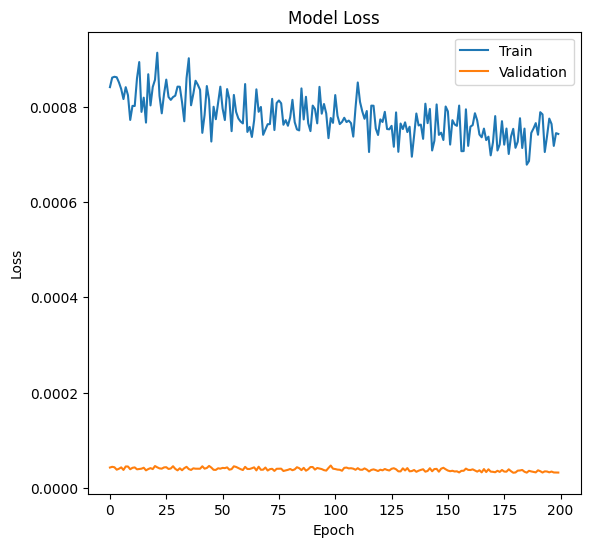

In [58]:
# Plot training & validation loss values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

In [59]:
# Predict X_train and X_val
p_train = model.predict(X_train)
print(p_train.shape)
p_train

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(3953, 1)


array([[0.10776619],
       [0.10773146],
       [0.10775635],
       ...,
       [0.155397  ],
       [0.15047356],
       [0.1488028 ]], dtype=float32)

In [60]:
# # Predict X_train and X_val
# p_train = model.predict(X_train)
# p_train = scaler.inverse_transform(p_train)
# p_val = model.predict(X_val)
# p_val = scaler.inverse_transform(p_val)

# # Compare p_train and y_train
# plt.plot(p_train, color='red', label='prediction on training samples')
# plt.plot(scaler.inverse_transform(y_train.reshape((-1, 1))), color='blue', label='y_train')
# plt.xlabel('No. of Trading Days')
# plt.ylabel('Opening Value')
# plt.legend(loc='upper left')
# fig = plt.gcf()
# fig.set_size_inches(30,10)
# plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Inverted (using stock prices)
Mean Absolute Error (MAE): 4.790040296225037
Mean Squared Error (MSE): 174.50555068931155
Root Mean Squared Error (RMSE): 13.210054908641052
Using MinMaxScaler
Mean Absolute Error (MAE): 0.011997596233500399
Mean Squared Error (MSE): 0.0010947611975290958
Root Mean Squared Error (RMSE): 0.03308717572608904


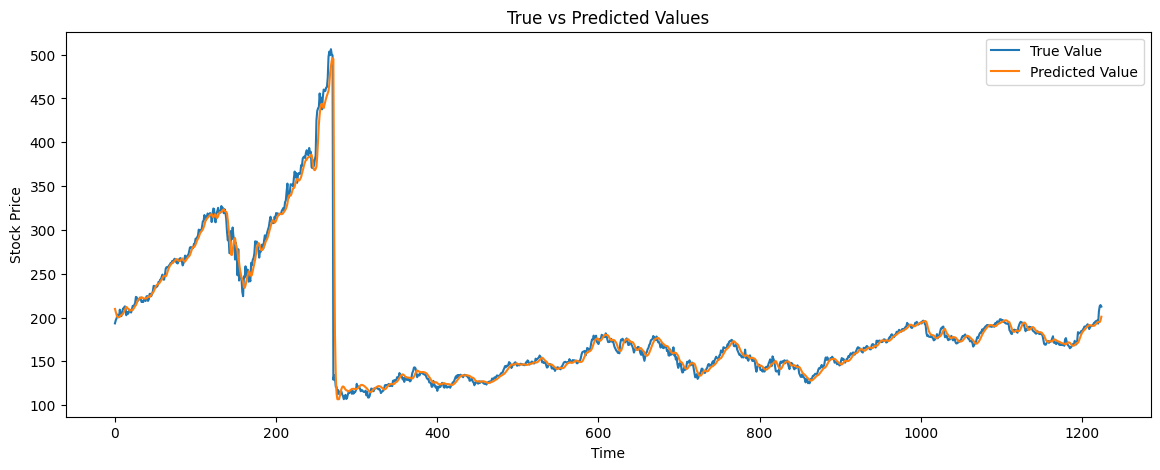

In [61]:
# Generate predictions
y_pred = model.predict(X_test)

full_test_set = np.zeros((len(y_test), feature_count))
full_test_set[:, 3] = y_test
y_test_inverse = scaler.inverse_transform(full_test_set)[:, 3]

full_pred_set = np.zeros((len(y_pred), feature_count))
full_pred_set[:, 3] = y_pred[:, 0]  # Ensure y_pred is 2D
y_pred_inverse = scaler.inverse_transform(full_pred_set)[:, 3]

print("Inverted (using stock prices)")
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')


print("Using MinMaxScaler")
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plotting
plt.figure(figsize=(14, 5))
plt.plot(y_test_inverse, label='True Value')
plt.plot(y_pred_inverse, label='Predicted Value')
plt.title('True vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


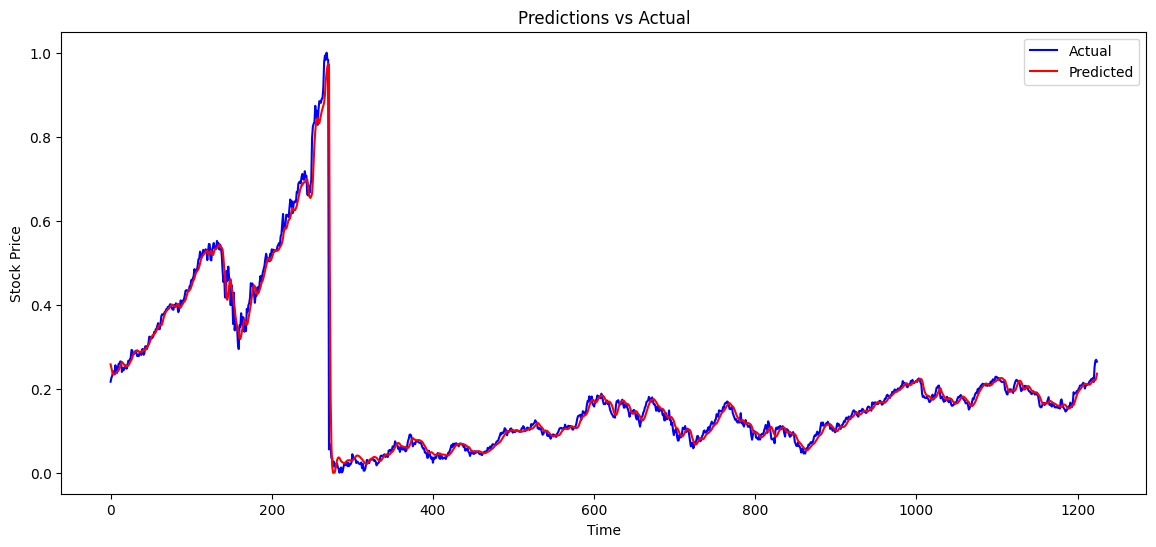

In [62]:
# Generate predictions
y_pred = model.predict(X_test)

# Plot predictions vs actual results
plt.figure(figsize=(14, 6))
plt.plot(y_test, color='blue', label='Actual')
plt.plot(y_pred, color='red', label='Predicted')
plt.title('Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(['Actual', 'Predicted'], loc='upper right')
plt.show()

In [63]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - mae: 0.0142    
test loss, test acc: [0.0010947611881420016, 0.011997595429420471]


In [42]:
# def backtest_strategy(predictions, actual_prices, initial_capital=10000, buy_threshold_percent=1.5, sell_threshold_percent=1.5, transaction_cost=0.001):
#     capital = initial_capital
#     position = 0
#     trades = []

#     for i in range(len(predictions) - 1):
#         current_price = actual_prices[i]
#         next_price_prediction = predictions[i + 1]
        
#         # Calculate percentage change
#         percent_increase = (next_price_prediction - current_price) / current_price * 100
#         percent_decrease = (current_price - next_price_prediction) / current_price * 100

#         # Define trade size factors based on percent change
#         if percent_increase >= buy_threshold_percent:
#             # Calculate trade size: Use a fraction of capital for buying
#             trade_size_fraction = 0.05  # Start with 5% of available capital
#             trade_size = capital * trade_size_fraction

#             if trade_size > 0:
#                 buy_price = current_price
#                 amount_to_buy = trade_size / buy_price
#                 capital_spent = buy_price * amount_to_buy * (1 + transaction_cost)
#                 capital -= capital_spent
#                 position += amount_to_buy
#                 trades.append(('Buy', i, buy_price, amount_to_buy, trade_size))
        
#         elif percent_decrease >= sell_threshold_percent:
#             if position > 0:
#                 trade_size_fraction = 0.05  # Start with 5% of current position value
#                 trade_size = position * trade_size_fraction

#                 sell_price = current_price
#                 capital_earned = trade_size * sell_price * (1 - transaction_cost)
#                 capital += capital_earned
#                 position -= trade_size / sell_price
#                 trades.append(('Sell', i, sell_price, trade_size, position))

#     # Calculate final capital
#     final_value = capital + (position * actual_prices[-1])
#     return final_value, trades


In [43]:
# # Example usage
# buy_threshold_percent = 1.5  # Percent increase threshold for buying
# sell_threshold_percent = 1.5  # Percent decrease threshold for selling

# final_value, trades = backtest_strategy(y_pred_inverse, y_test_inverse, buy_threshold_percent=buy_threshold_percent, sell_threshold_percent=sell_threshold_percent)
# print(f"Final Portfolio Value with Adjusted Strategy: ${final_value:.2f}")
# print(f"Trades Executed: {trades}")

In [44]:
# def backtest_strategy_random(predictions, actual_prices, initial_capital=10000, transaction_cost=0.001, trade_fraction=0.05):
#     capital = initial_capital
#     position = 0
#     trades = []

#     for i in range(len(predictions) - 1):
#         current_price = actual_prices[i]
#         next_price_prediction = predictions[i + 1]

#         # Randomly decide whether to buy, sell, or hold
#         action = random.choice(['buy', 'sell', 'hold'])

#         if action == 'buy':
#             # Calculate trade size: Use 5% of available capital
#             trade_size = capital * trade_fraction
#             if trade_size > 0:
#                 buy_price = current_price
#                 amount_to_buy = trade_size / buy_price
#                 capital_spent = buy_price * amount_to_buy * (1 + transaction_cost)
#                 capital -= capital_spent
#                 position += amount_to_buy
#                 trades.append(('Buy', i, buy_price, amount_to_buy, trade_size))

#         elif action == 'sell':
#             if position > 0:
#                 trade_size = position * trade_fraction
#                 sell_price = current_price
#                 capital_earned = trade_size * sell_price * (1 - transaction_cost)
#                 capital += capital_earned
#                 position -= trade_size / sell_price
#                 trades.append(('Sell', i, sell_price, trade_size, position))

#     # Calculate final capital
#     final_value = capital + (position * actual_prices[-1])
#     return final_value, trades

In [45]:
# # Example usage
# final_value, trades = backtest_strategy_random(y_pred_inverse, y_test_inverse)
# print(f"Final Portfolio Value with Random Strategy: ${final_value:.2f}")
# print(f"Trades Executed: {trades}")